In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus.scalarizers import Scalarizer
from olympus.objects import ParameterVector, ParameterContinuous
from olympus.campaigns import ParameterSpace

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set


sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
#---------------------------------------
# LOAD DATASET AND SET RANK INFORMATION
#---------------------------------------

lookup = pd.read_csv('../reference-and-data/lookup_table_multiobj.csv')
print(lookup.shape)

# select only the feasible syntheses and rank them
lookup_feas = lookup[lookup.synthesis_success==1]
print(lookup_feas.shape)
lookup_feas.head()
# lookup_feas = lookup_feas.sort_values(by='abl1_pIC50', ascending=False)
# lookup_feas['rank'] = np.arange(lookup_feas.shape[0])+1
# lookup_feas.head()

(270, 12)
(213, 12)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,kit_pIC50,pdgf_pIC50
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328,7.559847,7.953599
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000,7.617657,7.895027
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000,7.654378,7.815624
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000,7.306833,7.395175
5,8-1,22-6,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cnccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.638272,1.000000,7.247814,7.504766


In [3]:
value_space = ParameterSpace()
value_space.add(ParameterContinuous(name='abl1_pIC50'))
value_space.add(ParameterContinuous(name='kit_pIC50'))
value_space.add(ParameterContinuous(name='pdgf_pIC50'))

scalarizer = Scalarizer(
                kind='Hypervolume',
                value_space=value_space,
                goals=['max', 'max', 'max'],
            )
vals = lookup_feas[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50']].values
w_ref = np.amin(vals, axis=0) # reference point for hypervolume calculation
print(w_ref)
scal_vals = scalarizer.scalarize(vals)
lookup_feas['scal_vals'] = scal_vals
lookup_feas = lookup_feas.sort_values(by='scal_vals')
lookup_feas

[4.87859145 6.13139626 5.69063761]


/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_61223/1656909073.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookup_feas['scal_vals'] = scal_vals


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,kit_pIC50,pdgf_pIC50,scal_vals
30,8-2,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,1,1.000000,1,7.920819,1.000000,7.906951,7.924232,0.000000
28,8-2,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,1,1.000000,1,7.721246,1.000000,7.873886,8.008555,0.048383
248,19,22-6,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cnc2cnccn12,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5cnccn45)n(C...,1,1.000000,1,9.397940,1.000000,7.446388,7.553269,0.082522
256,19,22-14,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cnc2cn[nH]c2c1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5cn[nH]c5c4)...,1,1.000000,1,8.221849,1.000000,7.654087,7.804045,0.108267
263,19,22-21,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cncnc1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncnc4)n(C)n3)c...,1,1.000000,1,8.154902,1.000000,7.643421,7.828636,0.122148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,8-5,22-16,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccncc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccncc1,1,0.984431,0,4.961542,7.042252,6.487264,5.812753,0.999701
127,8-5,22-20,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccc(F)cc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccc(F)cc1,1,0.987699,0,4.972600,7.047935,6.681064,5.746238,0.999762
125,8-5,22-18,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1cccc(C#N)c1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1cccc(C#N)c1,1,1.000000,1,5.000000,1.000000,6.131396,5.830789,1.000000
124,8-5,22-17,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccccc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccccc1,1,1.000000,1,5.000000,1.000000,6.398337,5.690638,1.000000


In [4]:
optimal_params = ['8-2', '22-4']

In [5]:
# get the pareto set
params = lookup_feas[['template_name', 'alkyne_name']].values
vals   = -lookup_feas[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50']].values
pareto_front, pareto_set = get_pareto_set(params, vals)
pareto_set = pareto_set.tolist()

In [6]:
len(pareto_set)

19


## Load results


In [7]:
#--------
# RANDOM
#--------

# random
with open('random/results.pkl', 'rb') as content:
    data_random = pickle.load(content)

    
#---------
# GRYFFIN
#---------

# # naive
# with open('naive_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_naive_naive_0 = pickle.load(content)
# with open('naive_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_naive_fia_1000 = pickle.load(content)
    
# with open('static_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_static_naive_0 = pickle.load(content)
# with open('static_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_static_fia_1000 = pickle.load(content)
    
# with open('dynamic_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_dynamic_naive_0 = pickle.load(content)
# with open('dynamic_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_dynamic_fia_1000 = pickle.load(content)
    
    
# # fwa
# with open('naive_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_naive_fwa_0 = pickle.load(content)

# with open('static_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_static_fwa_0 = pickle.load(content)
    
# with open('dynamic_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_dynamic_fwa_0 = pickle.load(content)
    
    
# fca
# with open('naive_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_naive_fca_02 = pickle.load(content)
# with open('naive_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_naive_fca_05 = pickle.load(content)
# with open('naive_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_naive_fca_08 = pickle.load(content)
    
# with open('static_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_static_fca_02 = pickle.load(content)
# with open('static_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_static_fca_05 = pickle.load(content)
# with open('static_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_static_fca_08 = pickle.load(content)
    
# with open('dynamic_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_dynamic_fca_02 = pickle.load(content)
# with open('dynamic_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_dynamic_fca_05 = pickle.load(content)
# with open('dynamic_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_dynamic_fca_08 = pickle.load(content)
    
# # fia
# with open('naive_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_naive_fia_05 = pickle.load(content)
# with open('naive_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_naive_fia_1 = pickle.load(content)
# with open('naive_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_naive_fia_2 = pickle.load(content)
    
# with open('static_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_static_fia_05 = pickle.load(content)
# with open('static_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_static_fia_1 = pickle.load(content)
# with open('static_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_static_fia_2 = pickle.load(content)
    
# with open('dynamic_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_dynamic_fia_05 = pickle.load(content)
# with open('dynamic_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_dynamic_fia_1 = pickle.load(content)
# with open('dynamic_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_dynamic_fia_2 = pickle.load(content)
    

#---------
# BOTORCH
#---------

# naive
with open('wodesc_botorch-naive-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_naive_0 = pickle.load(content)
with open('wodesc_botorch-naive-replace/results.pkl', 'rb') as content:
    data_wodesc_botorch_naive_replace = pickle.load(content)
with open('wodesc_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_wodesc_botorch_fia_1000 = pickle.load(content)
    
with open('desc_mord_botorch-naive-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_naive_0 = pickle.load(content)
with open('desc_mord_botorch-naive-replace/results.pkl', 'rb') as content:
    data_desc_mord_botorch_naive_replace = pickle.load(content)
with open('desc_mord_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fia_1000 = pickle.load(content)
    
    
# fwa
with open('wodesc_botorch-fwa-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_fwa_0 = pickle.load(content)
    
with open('desc_mord_botorch-fwa-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fwa_0 = pickle.load(content)
    
    
# fca
with open('wodesc_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_wodesc_botorch_fca_02 = pickle.load(content)
with open('wodesc_botorch-fca-0.5/results.pkl', 'rb') as content:
    data_wodesc_botorch_fca_05 = pickle.load(content)
with open('wodesc_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_wodesc_botorch_fca_08 = pickle.load(content)
    
    
with open('desc_mord_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fca_02 = pickle.load(content)
with open('desc_mord_botorch-fca-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fca_05 = pickle.load(content)
with open('desc_mord_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fca_08 = pickle.load(content)
    
# fia
with open('wodesc_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_wodesc_botorch_fia_05 = pickle.load(content)
with open('wodesc_botorch-fia-1/results.pkl', 'rb') as content:
    data_wodesc_botorch_fia_1 = pickle.load(content)
with open('wodesc_botorch-fia-2/results.pkl', 'rb') as content:
    data_wodesc_botorch_fia_2 = pickle.load(content)

with open('desc_mord_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fia_05 = pickle.load(content)
with open('desc_mord_botorch-fia-1/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fia_1 = pickle.load(content)
with open('desc_mord_botorch-fia-2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_fia_2 = pickle.load(content)
    

# 0 --> without descriptors
# 0 --> with descriptors

all_data = [
    # random
    {'method': 'random', 'planner': 'random', 'params': 'random', 'desc': 'wodesc', 'data': data_random},
    # gryffin
#     # naive
#     {'method': 'naive_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'naive', 'data': data_naive_naive_0},
#     {'method': 'naive_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'naive', 'data': data_naive_fia_1000},
#     {'method': 'naive_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'naive', 'data': data_naive_fwa_0},
#     {'method': 'naive_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'naive', 'data': data_naive_fca_02},
#     {'method': 'naive_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'naive', 'data': data_naive_fca_05},
#     {'method': 'naive_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'naive', 'data': data_naive_fca_08},
#     {'method': 'naive_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'naive', 'data': data_naive_fia_05},
#     {'method': 'naive_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'naive', 'data': data_naive_fia_1},
#     {'method': 'naive_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'naive', 'data': data_naive_fia_2},
#     # static
#     {'method': 'static_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'static', 'data': data_static_naive_0},
#     {'method': 'static_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'static', 'data': data_static_fia_1000},
#     {'method': 'static_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'static', 'data': data_static_fwa_0},
#     {'method': 'static_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'static', 'data': data_static_fca_02},
#     {'method': 'static_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'static', 'data': data_static_fca_05},
#     {'method': 'static_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'static', 'data': data_static_fca_08},
#     {'method': 'static_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'static', 'data': data_static_fia_05},
#     {'method': 'static_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'static', 'data': data_static_fia_1},
#     {'method': 'static_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'static', 'data': data_static_fia_2},
#     # dynamic
#     {'method': 'dynamic_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'dynamic', 'data': data_dynamic_naive_0},
#     {'method': 'dynamic_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'dynamic', 'data': data_dynamic_fia_1000},
#     {'method': 'dynamic_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'dynamic', 'data': data_dynamic_fwa_0},
#     {'method': 'dynamic_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'dynamic', 'data': data_dynamic_fca_02},
#     {'method': 'dynamic_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'dynamic', 'data': data_dynamic_fca_05},
#     {'method': 'dynamic_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'dynamic', 'data': data_dynamic_fca_08},
#     {'method': 'dynamic_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'dynamic', 'data': data_dynamic_fia_05},
#     {'method': 'dynamic_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'dynamic', 'data': data_dynamic_fia_1},
#     {'method': 'dynamic_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'dynamic', 'data': data_dynamic_fia_2},
#     # botorch
    # wodesc
     {'method': 'wodesc_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'wodesc', 'data': data_wodesc_botorch_naive_0},
     {'method': 'wodesc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'wodesc', 'data': data_wodesc_botorch_naive_replace},
     {'method': 'wodesc_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'wodesc', 'data': data_wodesc_botorch_fia_1000},
     {'method': 'wodesc_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'wodesc', 'data': data_wodesc_botorch_fwa_0},
     {'method': 'wodesc_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'wodesc', 'data': data_wodesc_botorch_fca_02},
     {'method': 'wodesc_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'wodesc', 'data': data_wodesc_botorch_fca_05},
     {'method': 'wodesc_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'wodesc', 'data': data_wodesc_botorch_fca_08},
     {'method': 'wodesc_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'wodesc', 'data': data_wodesc_botorch_fia_05},
     {'method': 'wodesc_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'wodesc', 'data': data_wodesc_botorch_fia_1},
     {'method': 'wodesc_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'wodesc', 'data': data_wodesc_botorch_fia_2},
    # desc mord
    {'method': 'desc_mord_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_naive_0},
    {'method': 'desc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_naive_replace},
    {'method': 'desc_mord_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fia_1000},
    {'method': 'desc_mord_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fwa_0},
    {'method': 'desc_mord_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fca_02},
    {'method': 'desc_mord_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fca_05},
    {'method': 'desc_mord_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fca_08},
    {'method': 'desc_mord_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fia_05},
    {'method': 'desc_mord_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fia_1},
    {'method': 'desc_mord_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'desc-mord', 'data': data_desc_mord_botorch_fia_2}
]
    
# print out the number of repeated runs for each strategy
    
print('NUM RANDOM : ', len(data_random))

print('-'*30)


print('NUM WODESC-BOTORCH-NAIVE-0 : ', len(data_wodesc_botorch_naive_0))
print('NUM WODESC-BOTORCH-NAIVE-REPLACE : ', len(data_wodesc_botorch_naive_replace))
print('NUM WODESC-BOTORCH-FIA-1000 : ', len(data_wodesc_botorch_fia_1000))

print('NUM WODESC-BOTORCH-FWA-0 : ', len(data_wodesc_botorch_fwa_0))

print('NUM WODESC-BOTORCH-FCA-02 : ', len(data_wodesc_botorch_fca_02))
print('NUM WODESC-BOTORCH-FCA-05 : ', len(data_wodesc_botorch_fca_05))
print('NUM WODESC-BOTORCH-FCA-08 : ', len(data_wodesc_botorch_fca_08))

print('NUM WODESC-BOTORCH-FIA-05 : ', len(data_wodesc_botorch_fia_05))
print('NUM WODESC-BOTORCH-FIA-1 : ', len(data_wodesc_botorch_fia_1))
print('NUM WODESC-BOTORCH-FIA-2 : ', len(data_wodesc_botorch_fia_2))

print('')

print('NUM DESC-MORD-BOTORCH-NAIVE-0 : ', len(data_desc_mord_botorch_naive_0))
print('NUM DESC-MORD-BOTORCH-NAIVE-REPLACE : ', len(data_desc_mord_botorch_naive_replace))
print('NUM DESC-MORD-BOTORCH-FIA-1000 : ', len(data_desc_mord_botorch_fia_1000))

print('NUM DESC-MORD-BOTORCH-FWA-0 : ', len(data_desc_mord_botorch_fwa_0))

print('NUM DESC-MORD-BOTORCH-FCA-02 : ', len(data_desc_mord_botorch_fca_02))
print('NUM DESC-MORD-BOTORCH-FCA-05 : ', len(data_desc_mord_botorch_fca_05))
print('NUM DESC-MORD-BOTORCH-FCA-08 : ', len(data_desc_mord_botorch_fca_08))

print('NUM DESC-MORD-BOTORCH-FIA-05 : ', len(data_desc_mord_botorch_fia_05))
print('NUM DESC-MORD-BOTORCH-FIA-1 : ', len(data_desc_mord_botorch_fia_1))
print('NUM DESC-MORD-BOTORCH-FIA-2 : ', len(data_desc_mord_botorch_fia_2))

NUM RANDOM :  50
------------------------------
NUM WODESC-BOTORCH-NAIVE-0 :  50
NUM WODESC-BOTORCH-NAIVE-REPLACE :  50
NUM WODESC-BOTORCH-FIA-1000 :  50
NUM WODESC-BOTORCH-FWA-0 :  50
NUM WODESC-BOTORCH-FCA-02 :  31
NUM WODESC-BOTORCH-FCA-05 :  50
NUM WODESC-BOTORCH-FCA-08 :  47
NUM WODESC-BOTORCH-FIA-05 :  50
NUM WODESC-BOTORCH-FIA-1 :  20
NUM WODESC-BOTORCH-FIA-2 :  50

NUM DESC-MORD-BOTORCH-NAIVE-0 :  50
NUM DESC-MORD-BOTORCH-NAIVE-REPLACE :  50
NUM DESC-MORD-BOTORCH-FIA-1000 :  50
NUM DESC-MORD-BOTORCH-FWA-0 :  18
NUM DESC-MORD-BOTORCH-FCA-02 :  42
NUM DESC-MORD-BOTORCH-FCA-05 :  50
NUM DESC-MORD-BOTORCH-FCA-08 :  1
NUM DESC-MORD-BOTORCH-FIA-05 :  7
NUM DESC-MORD-BOTORCH-FIA-1 :  7
NUM DESC-MORD-BOTORCH-FIA-2 :  50


In [8]:
#-------------
# SET PALETTE
#-------------
mypalette = {
        'random': ['gray'],
        'naive':['#c7f9cc', '#57cc99'], #'#2d6a4f'], 
        'fwa':['#ff9b85'], 
        'fca':['#fbe9b1', '#f4cb48', '#ae870a'], 
        'fia':['#caf0f8', '#00b4d8', '#0077b6'],
}

In [12]:
def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)

def fill_nans(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out
    

def get_traces(campaigns, scalarizer, return_n_best_params=10):
    traces = []
    best_n_params = []
    num_pareto_set = []
    num_evals_full_pareto = []
    num_evals_one_pareto = []
    num_evals_best = []
    for df in campaigns:
#         print(campaign.observations.get_values().shape)
        df = df.fillna(method='ffill',axis=0)
        if np.isnan(df.iloc[0, -3:]['abl1_pIC50']):
            df.iloc[0, -3:] = 0.
        values = df[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50_col']].values
       
        params = df[['template', 'alkyne']].values
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
        sort_idx = np.argsort(scalarized)
        best_n_params.append(list(params[sort_idx][:return_n_best_params]))
        
        num_pareto = 0
        num_pareto_ = []
        
        for ix, param in enumerate(params):
            if param.tolist() in pareto_set:
                num_pareto+=1
            num_pareto_.append(num_pareto)
            if param.tolist()==optimal_params:
                num_evals_best.append(ix+1)
        num_pareto_set.append(num_pareto_)
        
        num_evals_full_pareto.append(
            np.where(np.array(num_pareto_)==len(pareto_set))[0][0]+1
        )
        num_evals_one_pareto.append(
            np.where(np.array(num_pareto_)>0.)[0][0]+1
        )
    return (
            np.array(traces), np.array(num_pareto_set), 
            np.array(num_evals_full_pareto), np.array(num_evals_one_pareto),
            best_n_params, np.array(num_evals_best)
    )


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)

def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True, linewidth=2):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=linewidth+1, zorder=11)
    ax.plot(x, mean, color=color, linewidth=linewidth, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_single(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    
    
def get_num_nans(data):
    num_nans = []
    for d in data:
        vals = d['abl1_pIC50'].values
        num_nans.append(np.sum(np.isnan(vals)))
        
    return num_nans

In [13]:
num_evals_full_par = {'method': [], 'desc': [], 'planner': [], 'params': [], 'num_evals': [], 'num_evals_one': [],
                      'num_evals_best': [], 'num_nans': [] }
for elem in all_data:
    print(elem['method'])
    print(elem['planner'])
    
    traces, num_pareto, num_evals_full_pareto, num_evals_one_pareto, _, num_evals_best = get_traces(elem['data'], scalarizer)
    num_nans = get_num_nans(elem['data'])
    elem['traces'] = traces
    elem['frac_pareto'] = num_pareto/len(pareto_set)
    
    num_runs = len(num_evals_full_pareto)
    num_evals_full_par['method'].extend([elem['method'] for _ in range(num_runs)])
    if elem['planner']=='random':
        desc_ = False 
    else:
        desc_ = elem['desc']
    num_evals_full_par['desc'].extend([desc_ for _ in range(num_runs)])
    num_evals_full_par['planner'].extend([elem['planner'] for _ in range(num_runs)])
    num_evals_full_par['params'].extend([elem['params'] for _ in range(num_runs)])
    num_evals_full_par['num_evals'].extend(num_evals_full_pareto.tolist())
    num_evals_full_par['num_evals_one'].extend(num_evals_one_pareto.tolist())
    num_evals_full_par['num_evals_best'].extend(num_evals_best.tolist())
    num_evals_full_par['num_nans'].extend(num_nans)
    
df_num_eval = pd.DataFrame(num_evals_full_par)

random
random
wodesc_botorch_naive-0
botorch
wodesc_botorch_naive-replace
botorch
wodesc_botorch_naive-fia-1000
botorch
wodesc_botorch_fwa-0
botorch
wodesc_botorch_fca-0.2
botorch
wodesc_botorch_fca-0.5
botorch
wodesc_botorch_fca-0.8
botorch
wodesc_botorch_fia-0.5
botorch
wodesc_botorch_fia-1
botorch
wodesc_botorch_fia-2
botorch
desc_mord_botorch_naive-0
botorch
desc_botorch_naive-replace
botorch
desc_mord_botorch_naive-fia-1000
botorch
desc_mord_botorch_fwa-0
botorch
desc_mord_botorch_fca-0.2
botorch
desc_mord_botorch_fca-0.5
botorch
desc_mord_botorch_fca-0.8
botorch
desc_mord_botorch_fia-0.5
botorch
desc_mord_botorch_fia-1
botorch
desc_mord_botorch_fia-2
botorch


In [55]:
df_num_eval

,method,desc,planner,params,num_evals,num_evals_one,num_evals_best
0,random,False,random,random,246,19,35
1,random,False,random,random,258,25,65
2,random,False,random,random,233,10,34
3,random,False,random,random,270,10,13
4,random,False,random,random,247,43,99
...,...,...,...,...,...,...,...
818,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,154,11,17
819,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,146,13,50
820,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,147,14,40
821,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,153,22,49


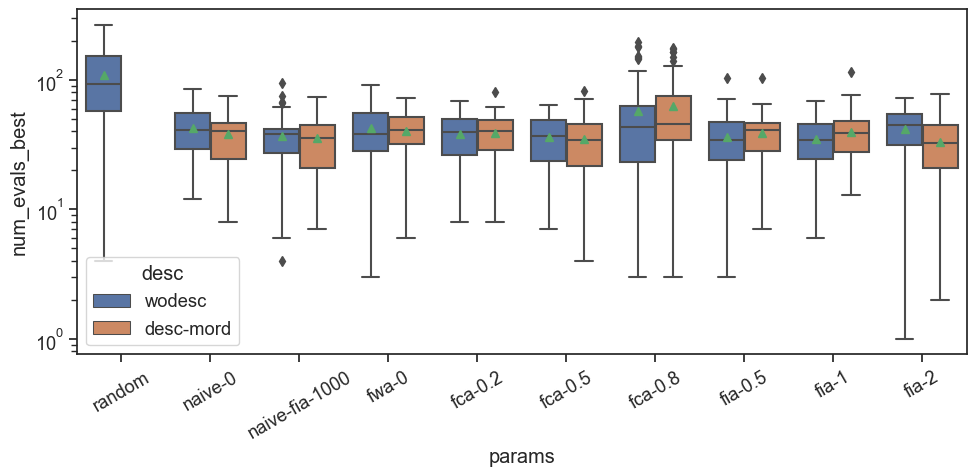

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(
        data=df_num_eval, 
        x='params', y='num_evals_best', hue='desc', ax=ax, showmeans=True)

plt.xticks(rotation=30)

ax.set_yscale('log')
plt.tight_layout()
plt.savefig('num_evals_best.png', dpi=300)

In [178]:
df_num_eval.groupby(by=['params', 'desc']).mean()

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_50757/389388803.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_num_eval.groupby(by=['params', 'desc']).mean()


num_evals  num_evals_one  num_evals_best
params         desc                                                
fca-0.2        desc-mord  130.863636      10.090909       39.545455
               wodesc     131.517241      12.586207       36.896552
fca-0.5        desc-mord  145.181818      12.318182       39.181818
               wodesc     169.821429       9.535714       35.928571
fca-0.8        desc-mord  209.181818      10.818182       54.181818
               wodesc     192.964286       9.750000       57.000000
fia-0.5        desc-mord  164.818182      13.318182       34.727273
               wodesc     159.045455       8.909091       31.590909
fia-1          desc-mord  135.136364      11.681818       41.318182
               wodesc     141.272727      15.136364       37.636364
fia-2          desc-mord  146.909091      11.636364       36.181818
               wodesc     145.227273      12.181818       40.772727
fwa-0          desc-mord  133.727273      11.272727       37.409091
               wodesc     131.181818      11.181818       42.227273
naive-0        desc-mord  146.220000      12.700000       38.420000
               wodesc     144.840000      13.100000       42.780000
naive-fia-1000 desc-mord  138.653846      10.730769       35.615385
               wodesc     140.863636      10.136364       35.909091
random         wodesc     257.620000      14.780000      109.480000

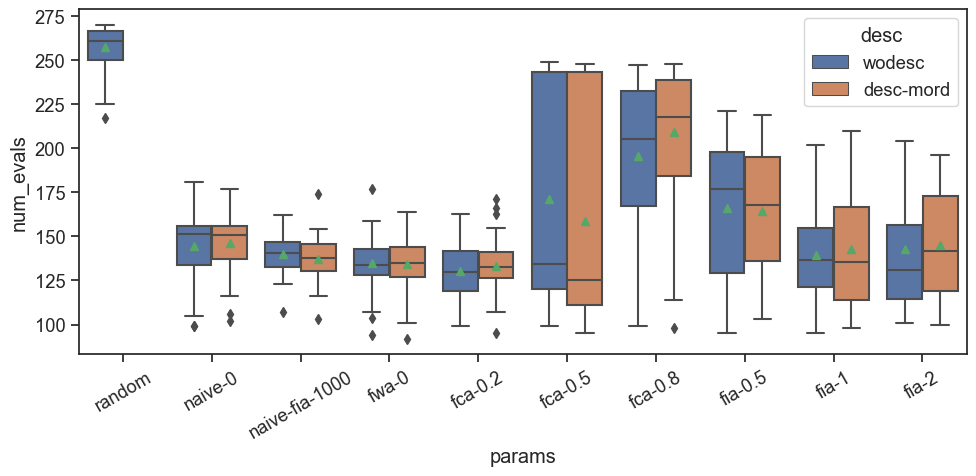

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_num_eval, x='params', y='num_evals', hue='desc', ax=ax, showmeans=True)

plt.xticks(rotation=30)

plt.tight_layout()
plt.savefig('num_evals_full_pareto.png', dpi=300)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'random'),
  Text(1, 0, 'naive-0'),
  Text(2, 0, 'naive-fia-1000'),
  Text(3, 0, 'fwa-0'),
  Text(4, 0, 'fca-0.2'),
  Text(5, 0, 'fca-0.5'),
  Text(6, 0, 'fca-0.8'),
  Text(7, 0, 'fia-0.5'),
  Text(8, 0, 'fia-1'),
  Text(9, 0, 'fia-2')])

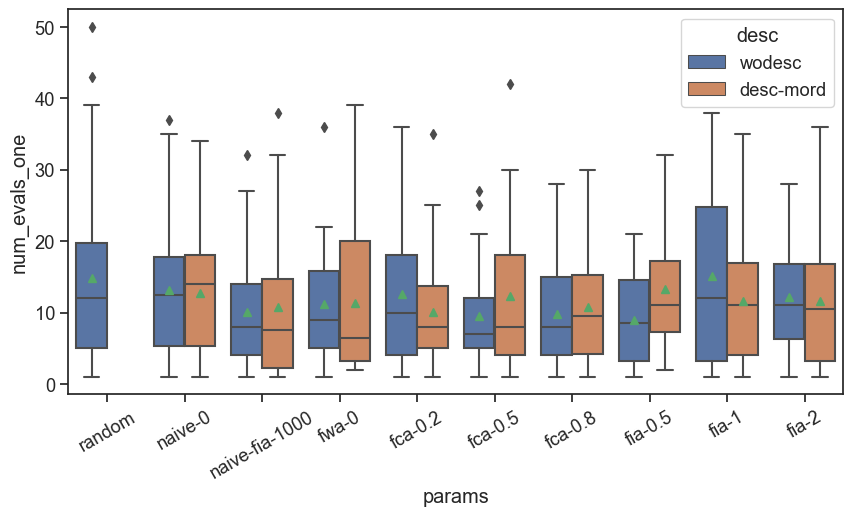

In [160]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=df_num_eval, x='params', y='num_evals_one', hue='desc', ax=ax, showmeans=True)

plt.xticks(rotation=30)

In [47]:
gb = df_num_eval.groupby(by=['planner', 'desc', 'params'])
group = gb.get_group(('random', False, 'random'))

In [43]:
gb.head()

,method,desc,planner,params,num_evals,num_evals_one,num_evals_best
0,random,wodesc,random,random,246,19,35
1,random,wodesc,random,random,258,25,65
2,random,wodesc,random,random,233,10,34
3,random,wodesc,random,random,270,10,13
4,random,wodesc,random,random,247,43,99
...,...,...,...,...,...,...,...
773,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,157,9,13
774,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,137,21,22
775,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,155,11,53
776,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,131,12,47


In [60]:
def get_pvalues(
        data, 
        metric, # 'botorch':['wodesc', 'desc']
        strategies={
                'random':['False'], 
                'botorch':['wodesc', 'desc-mord'],  
#                 'gryffin':['naive', 'static', 'dynamic']
        },
        constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                     'fca-0.2', 'fca-0.5', 'fca-0.8', 
                     'fia-0.5', 'fia-1', 'fia-2'],
    ):
    res = {'planner':[],'desc':[],'params':[], 'metric': []}
    gb = data.groupby(by=['planner', 'desc', 'params'])
    # random first
    #random = data[(data['planner']=='random')&(data['desc']==False)&(data['param']=='random')][metric].to_numpy()
    group = gb.get_group(('random', False, 'random'))
    mean = group.mean()[metric]
    
    res['planner'].append('random')
    res['desc'].append(False)
    res['params'].append('random')
    res['metric'].append(mean)
    
    for alg in ['botorch']: #'gryffin']:
        for desc in strategies[alg]:
            for param in constraints:
                group = gb.get_group((alg, desc, param))
                mean = group.mean()[metric]
                res['planner'].append(alg)
                res['desc'].append(desc)
                res['params'].append(param)
                res['metric'].append(mean)
                
    df = pd.DataFrame(res).sort_values(by='metric', ascending=True)
    
    signif = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric].to_numpy()
    
    signif.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric].to_numpy()
        
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
        if pval<0.05:
            stop=True
        else:
            signif.append(new)
            idx+=1
    return signif

In [61]:
def make_table(
    data,
    filename='mytable.txt',
    metric='num_evals_after',
    signif=[['dummy', 'dummy', 'dummy']],
    strategies={'random':['False'], 'botorch':['wodesc', 'desc-mord']},
    constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                 'fca-0.2', 'fca-0.5', 'fca-0.8', 
                 'fia-0.5', 'fia-1', 'fia-2'],
    num_dec=1,
):
    ''' generate a latex table with the optimization experiment results
    '''
    gb = data.groupby(by=['planner', 'desc', 'params'])
    
    num_cols = len(constraints)+1 # plus one for planner col
    num_rows = np.sum([len(val) for key, val in strategies.items()])-1 # minus 1 for random sampling
    
    col_headers = ['planner']+constraints
    
    col_str = ' '.join(['c' for _ in range(num_cols)])
    f = ''
    
    # table header
    f+='\\begin{table}[!ht]\n\centering\n\caption{\ldots}\n\label{\ldots}\n\\begin{tabular}{'+col_str+'}\n'
    f+= '\\toprule\n'
    f+= ' & '.join([header for header in col_headers]) + '\\\ \n'
    f+= '\midrule\n'
    
    # random sampling first
    f+='random & '
    group = gb.get_group(('random', False, 'random'))
    mean, sem = group.mean()[metric], group.sem()[metric]
    f += f'{round(mean,num_dec)} $\pm$ {round(sem,num_dec)} & '
    to_add = ''.join([f'$-$ & ' for _ in range(num_cols-3)])
    f+= to_add 
    f+= '$-$ \\\ \n'
    
    for alg in ['botorch']: #'gryffin']:
        for desc in strategies[alg]:
            f += f'{alg}-{desc} & '
            for param in constraints:
                group = gb.get_group((alg, desc, param))
                mean, sem = group.mean()[metric], group.sem()[metric]

                if not [alg, desc, param] in signif:
                    if param == constraints[-1]:
                        f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ \\\ \n'
                    else:
                        f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ &'
                else:
                    if param == constraints[-1]:
                        f+='$\\bm{'
                        f += f'{round(mean,num_dec)} \pm {round(sem,num_dec)}'
                        f+= '}$ \\\ \n'
                    else:
                        f+='$\\bm{'
                        f += f'{round(mean,num_dec)} \pm {round(sem,num_dec)}'
                        f+= '}$ & '

    # end of table
    f+='\\bottomrule\n'
    f+='\end{tabular}\n'
    f+='\end{table}\n'

    # write table to file
    with open(filename, 'w') as file:
        file.write(f)

In [66]:
signif = get_pvalues(data=df_num_eval, metric='num_evals')
make_table(
    data=df_num_eval,
    filename='num_eval_full_pareto.txt',
    metric='num_evals',
    signif=signif,
)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_38354/2176779876.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_38354/2176779876.py:29: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_38354/2047851622.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In additio

,method,desc,planner,params,num_evals,num_evals_one,num_evals_best
0,random,False,random,random,246,19,35
1,random,False,random,random,258,25,65
2,random,False,random,random,233,10,34
3,random,False,random,random,270,10,13
4,random,False,random,random,247,43,99
...,...,...,...,...,...,...,...
818,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,154,11,17
819,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,146,13,50
820,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,147,14,40
821,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,153,22,49


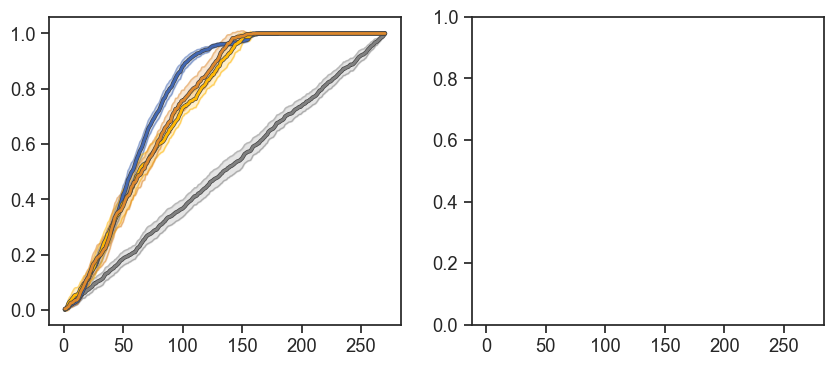

In [121]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4), sharex=True)

for data in all_data:
    
    if data['method'] == 'random':
        # plot on both axes
    
    elif 'wodesc' is in data['method']

plot_trace_mean(
    np.expand_dims(all_data[0]['frac_pareto'],1), obj_num=0, ax=axes[0], color='gray', label='Random'
)
plot_trace_mean(
    np.expand_dims(all_data[1]['frac_pareto'],1), obj_num=0, ax=axes[0], color='#4267B2', label='BO'
)
plot_trace_mean(
    np.expand_dims(all_data[2]['frac_pareto'],1), obj_num=0, ax=axes[0], color='#ffb703', label='BO'
)
plot_trace_mean(
    np.expand_dims(all_data[3]['frac_pareto'],1), obj_num=0, ax=axes[0], color='#dd882c', label='BO'
)

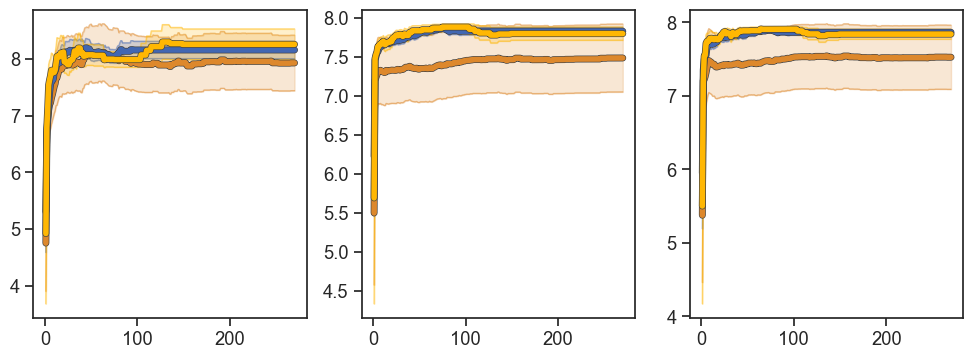

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4), sharex=True)

for i in range(3):
    plot_trace_mean(all_data[0]['traces'], obj_num=i, ax=axes[i], color='#dd882c', label='Random')
    plot_trace_mean(all_data[1]['traces'], obj_num=i, ax=axes[i], color='#4267B2', label='BO')
    plot_trace_mean(all_data[2]['traces'], obj_num=i, ax=axes[i], color='#ffb703', label='BO')


In [55]:
arr = all_data[1]['traces'][2,:,:]
arr

array([[5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28744398, 5.28744398,
        5.28744398, 5.28744398, 5.28744398, 5.28

In [68]:
arr = all_data[0]['data'][0]
arr

,template,alkyne,abl1_pIC50,kit_pIC50,pdgf_pIC50_col
0,16-1,22-14,NaN,NaN,NaN
1,8-4,22-12,6.630747,7.456830,6.948030
2,16-2,22-10,7.284335,7.741678,7.554442
3,8-3,22-1,NaN,NaN,NaN
4,16-2,22-18,NaN,NaN,NaN
...,...,...,...,...,...
265,8-1,22-19,5.922050,7.308702,7.583179
266,16-1,22-15,7.208953,7.392231,7.665008
267,16-4,22-26,6.964596,7.525312,6.412776
268,8-3,22-13,6.491724,6.709534,7.420006


In [74]:
arr

,template,alkyne,abl1_pIC50,kit_pIC50,pdgf_pIC50_col
0,16-1,22-14,0.000000,0.000000,0.000000
1,8-4,22-12,6.630747,7.456830,6.948030
2,16-2,22-10,7.284335,7.741678,7.554442
3,8-3,22-1,7.284335,7.741678,7.554442
4,16-2,22-18,7.284335,7.741678,7.554442
...,...,...,...,...,...
265,8-1,22-19,5.922050,7.308702,7.583179
266,16-1,22-15,7.208953,7.392231,7.665008
267,16-4,22-26,6.964596,7.525312,6.412776
268,8-3,22-13,6.491724,6.709534,7.420006


In [6]:
# def get_traces_min(data, replace_nan=True):
#     traces_min = []
#     for df in data:
#         trace = df.loc[:, 'obj'].to_numpy()
#         # if first is nan, replace with first non-nan
#         if replace_nan is True:
#             if np.isnan(trace[0]):
#                 for val in trace[1:]:
#                     if not np.isnan(val):
#                         trace[0] = val
#                         break
#         trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
#         traces_min.append(trace_min)
#     return np.array(traces_min)


# def get_traces_min_for_categorical(data, replace_nan=True):
#     traces_min = []
#     for df in data:
#         trace = np.zeros(100)  # up to 100
#         results = df.loc[:, 'obj'].to_numpy()[:100]  # up to 100
#         trace[:len(results)] = results
        
#         # if first is nan, replace with first non-nan
#         if replace_nan is True:
#             if np.isnan(trace[0]):
#                 for val in trace[1:]:
#                     if not np.isnan(val):
#                         trace[0] = val
#                         break
#         trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
#         traces_min.append(trace_min)
#     return np.array(traces_min)

def get_traces_max_for_categorical(data, replace_nan=True, up_to=100):
    traces_max = []
    for df in data:
        trace = np.zeros(up_to) 
        results = df.loc[:, 'abl1_pIC50'].to_numpy()[:up_to] 
        trace[:len(results)] = results
        
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
        trace_max = [np.nanmax(trace[:i+1]) for i in range(len(trace))]
        traces_max.append(trace_max)
    return np.array(traces_max)


def get_rank_traces_for_categorical(data, replace_nan=True, up_to=100):
    
    traces_min = []
    for df in data:
        trace = []
        template_names = df.loc[:, 'template_name'].tolist()[:up_to]
        alkyne_names = df.loc[:, 'alkyne_name'].tolist()[:up_to]
        #results  = df.loc[:, 'abl1_pIC50'].to_numpy()[:up_to]
        
        # get the corresponsing ranks
        for temp_name, alky_name in zip(template_names, alkyne_names):
            match = lookup_feas.loc[
                (lookup_feas.template_name==temp_name) &
                (lookup_feas.alkyne_name==alky_name)
            ]
            if len(match)==1:
                # feasible, add rank
                trace.append( match.loc[:, 'rank'].to_numpy()[0] )
            else:
                # not feasible, add nan 
                trace.append(np.nan)
            
        # if first is nan, replace with first non-nan
        if replace_nan is True:
            if np.isnan(trace[0]):
                for val in trace[1:]:
                    if not np.isnan(val):
                        trace[0] = val
                        break
                        
        trace_min = [np.nanmin(trace[:i+1]) for i in range(len(trace))]
        traces_min.append(trace_min)
        
    return np.array(traces_min)


def get_num_eval_top_x(data, top_x=1):
    ''' return number of evalautions needed to acheive at least 
    a top x candidate --> also returns the number of nans measured 
    up until the top_x candidate was found
    ''' 
    num_evals = []
    num_nans = []
    for df in data:
        num_eval = 1
        num_nan = 0
        
        try:
            template_names = df.loc[:, 'template_name'].tolist()
            alkyne_names = df.loc[:, 'alkyne_name'].tolist()
        except Exception as e:
            print('error : ', e)
            template_names = df.loc[:, 'template'].tolist()
            alkyne_names   = df.loc[:, 'alkyne'].tolist()
        
        # get the corresponsing ranks - stop when found top_x
        for temp_name, alky_name in zip(template_names, alkyne_names):
            match = lookup_feas.loc[
                (lookup_feas.template_name==temp_name) &
                (lookup_feas.alkyne_name==alky_name)
            ]
            if len(match)==1:
                # feasible, add rank
                rank = match.loc[:, 'rank'].to_numpy()[0] 
                if rank <= top_x:
                    # done
                    break
                else:
                    num_eval += 1     
            else:
                # infeasible
                num_nan+=1
                
        num_evals.append(num_eval)
        num_nans.append(num_nan)
        
    return num_evals, num_nans



def plot_min_rank_trace_mean(data, up_to, ax=None, color=None, label=None,  stde=False, unc=True, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_min = get_rank_traces_for_categorical(data, up_to=up_to) - shift
    
    mean = np.nanmean(traces_min, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_min, axis=0, ddof=1) / np.sqrt(np.shape(traces_min)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_min, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_min)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
     
    

def plot_max_trace_mean(data, up_to, ax=None, color=None, label=None,  stde=False, unc=True, shift=0.0):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_max = get_traces_max_for_categorical(data, up_to=up_to) - shift
#     else:
#         traces_max = get_traces_max(data) - shift
    
    mean = np.nanmean(traces_max, axis=0)
    if stde is True:
        # standard error
        stde = np.nanstd(traces_max, axis=0, ddof=1) / np.sqrt(np.shape(traces_max)[0] - 1)
    else:
        # standard deviation
        stde = np.nanstd(traces_max, axis=0, ddof=1)
        
    x = range(1, np.shape(traces_max)[1]+1, 1)

    ax.plot(x, mean, color='#444444', linewidth=5)
    ax.plot(x, mean, color=color, linewidth=4, label=label)
    
    if unc is True:
        ax.fill_between(x, y1=mean - 1.96*stde, y2=mean + 1.96*stde, alpha=0.2, color=color)
        ax.plot(x, mean - 1.96*stde, color=color, linewidth=1, alpha=0.5)
        ax.plot(x, mean + 1.96*stde, color=color, linewidth=1, alpha=0.5)
        
    
    
def plot_max_trace_median(data, up_to, ax=None, color=None, label=None, nboots=1000):
    
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
        
    traces_max = get_traces_max_for_categorical(data, replace_nan=True, up_to=up_to)

    median = np.median(traces_max, axis=0)
    q100, q75, q25, q0 = bootstrapped_iqr(traces_max, nboots=1000)
    x = range(1, np.shape(traces_max)[1] + 1, 1)

    ax.plot(x, median, color=color, label=label)
    ax.fill_between(x, y1=q25, y2=q75, alpha=0.2, color=color)
    ax.fill_between(x, y1=q0, y2=q100, alpha=0.2, color=color)
    
    
def bootstrapped_iqr(traces, nboots=100):
    boot_medians = []
    for b in range(nboots):
        boot_idx = np.random.randint(low=0, high=traces.shape[0], size=traces.shape[0])
        boot_traces = traces[boot_idx]
        boot_median = np.median(boot_traces, axis=0)
        boot_medians.append(boot_median)
        
    q75, q25 = np.percentile(np.array(boot_medians), [75 ,25], axis=0)
    q100 = np.max(traces, axis=0)
    q0 = np.min(traces, axis=0)
    return q100, q75, q25, q0



def get_cumulative(data):
    traces_max = get_traces_max_for_categorical(data)
    
    # if first merit is NaN, replace with next
    for i, trace in enumerate(traces_max):
        for j, merit in enumerate(trace):
            if np.isnan(merit) == True:
                found = False
                jdelta = 1
                # find first non-nan
                while found is False:
                    if np.isnan(traces_min[i, j+jdelta]) == False:
                        traces_min[i, j] = traces_min[i, j+jdelta]
                        found = True
                    else:
                        jdelta += 1
    
    sum_max = np.sum(traces_max, axis=1) 
    mean_max = np.mean(sum_max)
    med_max = np.median(sum_max)
    serr_max = np.std(sum_max) / np.sqrt(len(sum_max) - 1)
    return mean_max, serr_max



def number_of_nans(data, normalize=False):
    """normalise == True returns fraction of NaN instead of number of NaN"""
    num_nans = []
    for repeat in data:
        num_nans_i = sum(np.isnan(repeat['abl1_pIC50']))
#         if normalize is True:
#             num_nans_i = num_nans_i / len(repeat['abl1_pIC50'])
        num_nans.append(num_nans_i)
    return num_nans

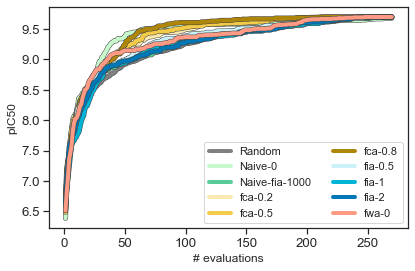

In [7]:
# #-----------------------
# # OBJECTIVE TRACE PLOTS
# #-----------------------

fig, ax = plt.subplots(1, 1)
up_to=270
# random
plot_max_trace_mean(data_random, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['random'][0], label='Random')
# naive
plot_max_trace_mean(data_naive_naive_0, up_to=up_to, ax=ax,unc=False,  stde=True, color=mypalette['naive'][0], label='Naive-0')
plot_max_trace_mean(data_naive_fia_1000, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['naive'][1], label='Naive-fia-1000')
# fca
plot_max_trace_mean(data_naive_fca_02, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fca'][0], label='fca-0.2')
plot_max_trace_mean(data_naive_fca_05, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fca'][1], label='fca-0.5')
plot_max_trace_mean(data_naive_fca_08, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fca'][2], label='fca-0.8')
# fia
plot_max_trace_mean(data_naive_fia_05, up_to=up_to, ax=ax,unc=False,  stde=True, color=mypalette['fia'][0], label='fia-0.5')
plot_max_trace_mean(data_naive_fia_1, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fia'][1], label='fia-1')
plot_max_trace_mean(data_naive_fia_2, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fia'][2], label='fia-2')
# fwa
plot_max_trace_mean(data_naive_fwa_0, up_to=up_to, ax=ax, unc=False, stde=True, color=mypalette['fwa'][0], label='fwa-0')


ax.legend(loc='lower right', ncol=2, fontsize=11)
ax.set_xlabel('# evaluations', fontsize=12)
ax.set_ylabel('pIC50', fontsize=12)



plt.tight_layout()
# plt.savefig('objective_traces_mean.png', dpi=300)